***
# <span style='color:Blue'> NLP classifier to predict the blog topic </span>
***

### <span style='color:red'>Note:</span>
- Due to computational constraints (limted RAM and processor), the notebook session was restarted multiple times.
- Thus analyses were performed in batches and the intermittent pickel files of object and models were saved and reused as needed
- Hence the numbering of executed cells are not in order

#### <span style='color:Blue'>Import the required packages</span>

In [5]:
# Perform operations on data frames
import pandas as pd              
#Perform numeric operations on data
import numpy as np               
#For static visualizations
import matplotlib.pyplot as plt  
%matplotlib inline 
#For advanced visualizations
import seaborn as sns
import random
import warnings
from tqdm import tqdm
from zipfile import ZipFile
import pickle
import json
import gc

# Helps to extract the data using regular expressions
import re

# Helps to remove the punctuation
import string,unicodedata

# It helps to remove the accented characters 
import unidecode

#It helps in fixing word contractions
import contractions

# It help to correct the spelling
from autocorrect import Speller
from ftlangdetect import detect

#Import html parser
from bs4 import BeautifulSoup

# Importing the NLTK library
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
lemmatizer = WordNetLemmatizer()

#Import word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Import sklearn related packages
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer         


# Import tensorflow related packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, InputLayer, Dense, Embedding, LSTM, SpatialDropout1D, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from tensorflow.keras import backend
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

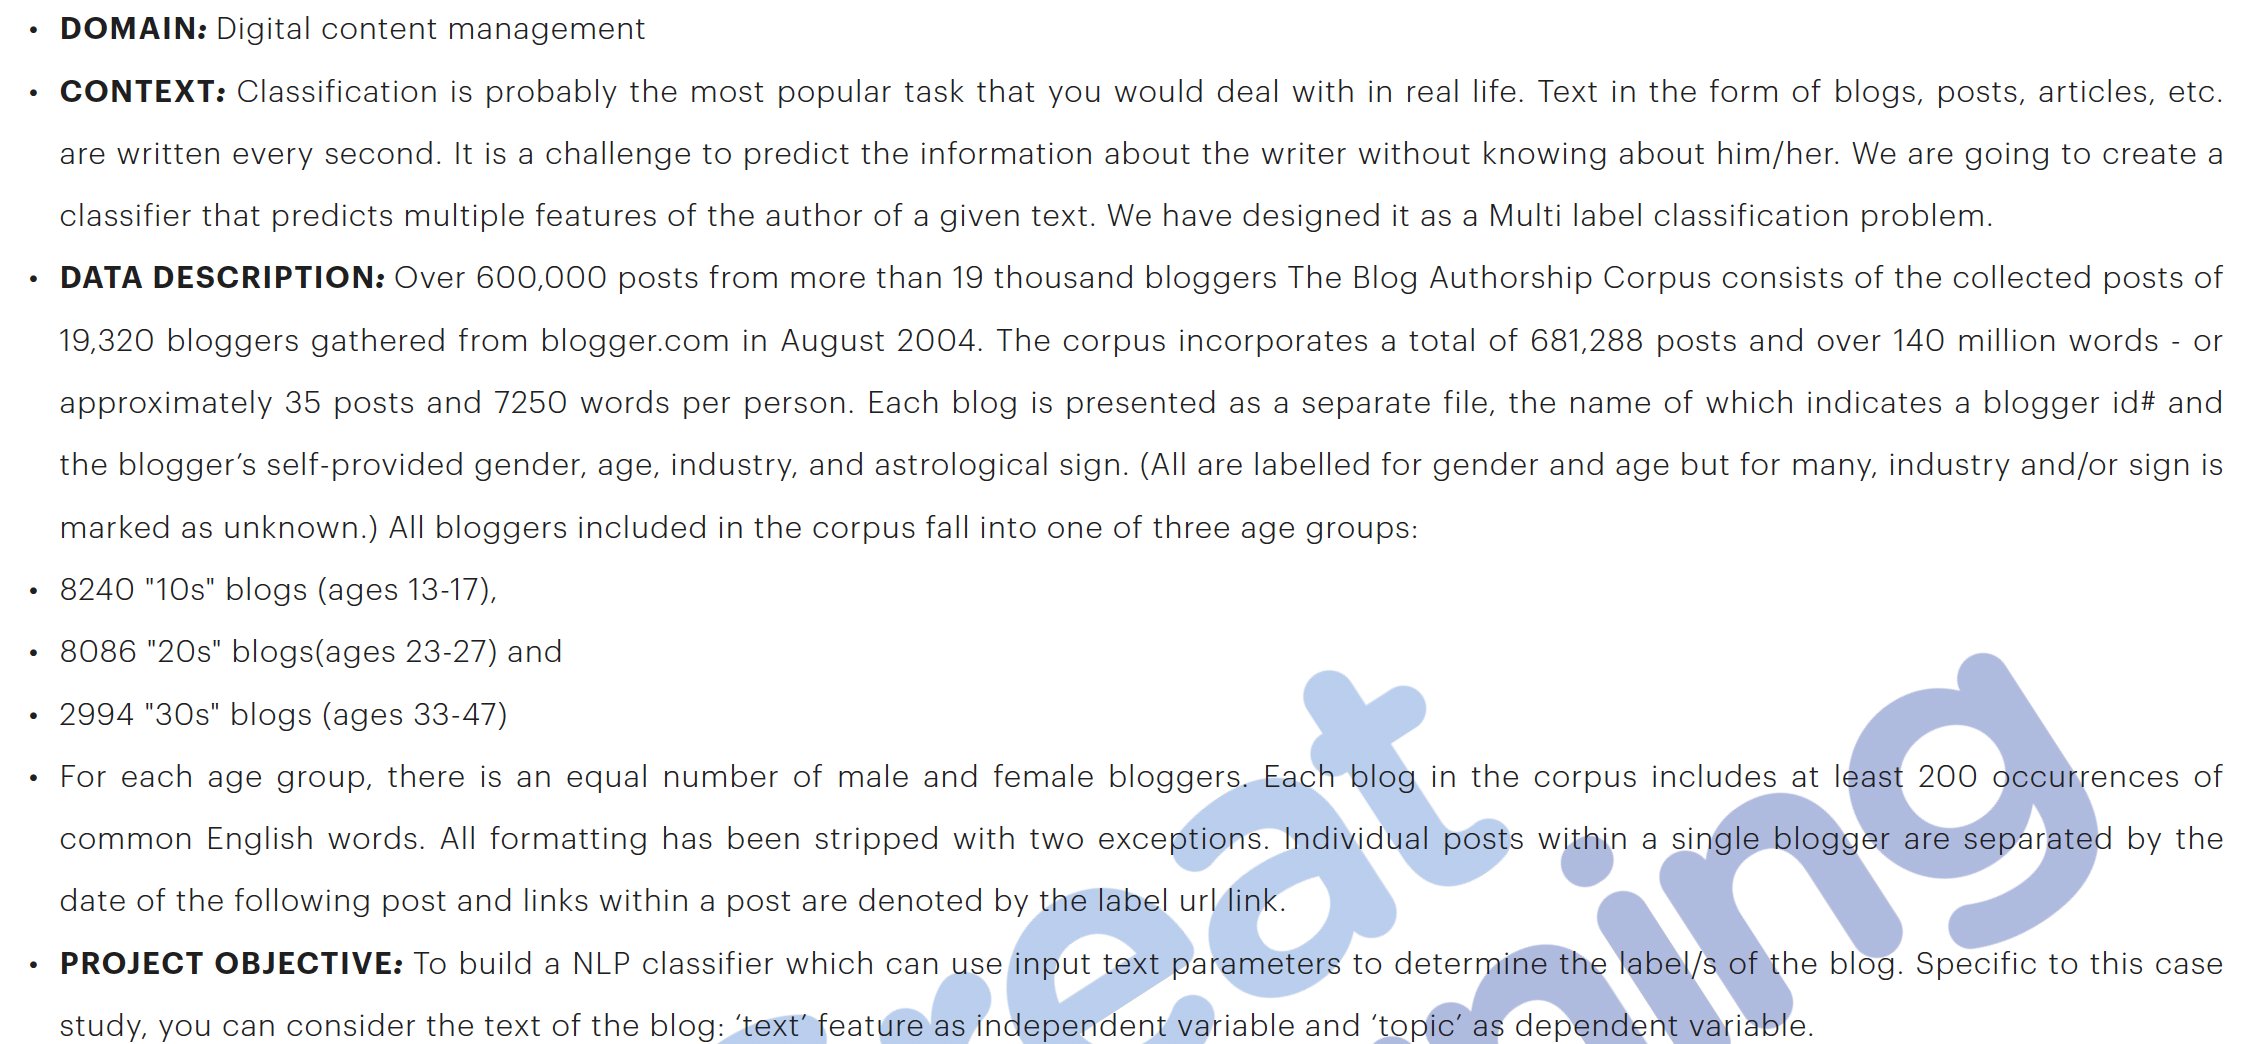

## Read and Analyse the data

### Data analysis outcome

In [2]:
file_name = "blogs.zip"
with ZipFile(file_name, 'r') as zip:
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
blogtext.csv                                   2019-09-20 22:33:20    800419647
Extracting all the files now...
Done!


In [90]:
df_blog = pd.read_csv("blogtext.csv")

In [4]:
df_blog.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [5]:
#Shape of the dataframe
df_blog.shape

(681284, 7)

In [6]:
#Check for missing values and data types
df_blog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [7]:
#Check the mean and max age group of female bloggers 
df_blog[df_blog['gender']=='female'].describe()

,id,age
count,3.360910e+05,336091.000000
mean,2.412285e+06,23.855087
std,1.228728e+06,7.845881
min,1.176200e+04,13.000000
25%,1.283465e+06,17.000000
50%,2.606666e+06,24.000000
75%,3.542946e+06,26.000000
max,4.337133e+06,48.000000


In [8]:
#Check the mean and max age group of female bloggers 
df_blog[df_blog['gender']=='male'].describe()

,id,age
count,3.451930e+05,345193.000000
mean,2.383702e+06,24.007529
std,1.265785e+06,7.726539
min,5.114000e+03,13.000000
25%,1.160168e+06,17.000000
50%,2.611645e+06,24.000000
75%,3.522724e+06,27.000000
max,4.337650e+06,48.000000


In [9]:
#Top topics covered by female bloggers
df_blog.loc[df_blog['gender']=='female', 'topic'].value_counts()

topic
indUnk                     146059
Student                     76988
Arts                        18947
Education                   15537
Non-Profit                   7430
Communications-Media         7099
Technology                   6323
Internet                     4149
Law                          4034
Engineering                  3980
Publishing                   3907
Marketing                    3244
Accounting                   3227
Science                      2950
Consulting                   2771
Fashion                      2388
Advertising                  2363
Museums-Libraries            2259
BusinessServices             2257
Government                   2042
HumanResources               1787
Religion                     1741
Banking                      1694
Sports-Recreation            1558
Telecommunications           1551
RealEstate                   1346
Tourism                      1072
Biotech                       849
Architecture                  848
Military

In [10]:
#Top topics covered by male bloggers
df_blog.loc[df_blog['gender']=='male', 'topic'].value_counts()

topic
indUnk                     104956
Student                     76915
Technology                  35732
Education                   14096
Arts                        13502
Communications-Media        13041
Internet                    11857
Engineering                  7673
Non-Profit                   7270
Law                          5006
Government                   4865
Science                      4319
Publishing                   3846
Religion                     3494
Chemicals                    3225
Consulting                   3091
Fashion                      2463
Banking                      2355
Military                     2340
Telecommunications           2340
Advertising                  2313
BusinessServices             2243
Transportation               1656
Manufacturing                1529
Marketing                    1525
RealEstate                   1524
Sports-Recreation            1480
Biotech                      1385
LawEnforcement-Security      1264
HumanRes

**<span style="color:blue"> Observations </span>**

- The dataset has a total of 6,81,284 rows and 7 features.
- Except for id and age which has integer data type rest all the columns are of the object type.
- There are `no null values` in the dataset.
- The `percentage` of male and female bloggers is 50.7% and 49.3%.
- More than `75% percentile` of the bloggers are under the age group of 26 in the case of females and 27 in the case of males.
- There are quite a lot of topics that are unknown and those contribute to the top of the topic list. The `student` topic is the 2nd best topic amongst `both males and females`. Apart from it, topic related to `Arts` is famous among `female` whereas topics related to `Technology` is famous among `Male`. 
   

In [11]:
# Removing unwanted columns 
colsToDrop = ["id", "gender", "age","sign", "date"]
df_blog.drop(columns=colsToDrop, inplace=True)

In [12]:
df_blog.head()

,topic,text
0,Student,"Info has been found (+/- 100 pages,..."
1,Student,These are the team members: Drewe...
2,Student,In het kader van kernfusie op aarde...
3,Student,testing!!! testing!!!
4,InvestmentBanking,Thanks to Yahoo!'s Toolbar I can ...


In [13]:
# checking for duplicate values
df_blog.duplicated().sum()

27846

In [14]:
#Remove duplicate entries except for the 1st occurrence
df_blog.drop_duplicates(keep='first', inplace = True)

In [15]:
#Confirm after removal of duplicates
df_blog.duplicated().sum()

0

In [16]:
#Reset the index of the dataframe
df_blog = df_blog.reset_index(drop = True)

In [17]:
#Shape of the dataframe after removal of the duplicates
df_blog.shape

(653438, 2)

In [18]:
#Count of each unique topic
df_blog['topic'].value_counts()

topic
indUnk                     240092
Student                    144467
Technology                  39011
Arts                        30918
Education                   29321
Communications-Media        19743
Internet                    15774
Non-Profit                  14580
Engineering                 11340
Law                          8876
Publishing                   7674
Science                      7177
Government                   6792
Consulting                   5801
Religion                     5172
Fashion                      4804
Marketing                    4717
Advertising                  4653
BusinessServices             4457
Banking                      3999
Chemicals                    3899
Telecommunications           3820
Accounting                   3693
Museums-Libraries            3090
Military                     3084
Sports-Recreation            3025
HumanResources               2999
RealEstate                   2860
Biotech                      2224
Manufact

**<span style="color:blue"> Observations </span>**

- There are a total of 27846 `duplicated` records and those were removed.
- There are quite a lot of topics that are unknown and those contribute to the top of the topic list. 

### Clean the Structured Data

### Missing value analysis and imputation

In [19]:
df_blog.shape

(653438, 2)

In [20]:
#Check any NA or null vlaues in the dataset
df_blog.isna().any()

topic    False
text     False
dtype: bool

In [21]:
#Check the text column for any blank spaces 
temp = df_blog['text'].value_counts().to_frame().reset_index()

In [22]:
temp.head(10)

,text,count
0,,27
1,,27
2,urlLink,26
3,,26
4,,25
5,,24
6,,24
7,,22
8,urlLink,20
9,,19


In [23]:
#Check the pattern of whitespaces
for index, row in temp.head(10).iterrows():
    print(index, "'",row['text'],"'")

0 '                      '
1 '                        '
2 '          urlLink    '
3 '                   '
4 '                  '
5 '                         '
6 '             '
7 '                       '
8 '              urlLink    '
9 '               '


**<span style="color:blue"> Observations </span>**

- It is noticed from above that there is more than 1 whitespace in the text field.
- So replace multiple whitespaces with single space. 

In [24]:
#Replace multiple blank spaces with a single space for uniformity
df_blog['text'] = [re.sub(r'\s+',' ',text) for text in df_blog['text']]

In [25]:
df_blog['text'].value_counts().to_frame().reset_index()

,text,count
0,,447
1,urlLink,348
2,urlLink &nbsp; urlLink,46
3,urlLink urlLink,44
4,test,37
...,...,...
609661,Me and Shiva went to a party at Andersons (sp...,1
609662,"Man, that party was sick! Seriously good and ...",1
609663,"Im still at Joelles house, lol i have just be...",1
609664,Last night before Maya ditched me to go to th...,1


In [26]:
#Filter blank spaces, urlLink, urlLink &nbsp; urlLink
toFilter = [' urlLink ',' urlLink urlLink ', ' urlLink &nbsp; urlLink ', ' ']
df_clean = df_blog[~(df_blog['text'].isin(toFilter))].reset_index(drop = True)

In [27]:
df_clean.head()

,topic,text
0,Student,"Info has been found (+/- 100 pages, and 4.5 M..."
1,Student,These are the team members: Drewes van der La...
2,Student,In het kader van kernfusie op aarde: MAAK JE ...
3,Student,testing!!! testing!!!
4,InvestmentBanking,Thanks to Yahoo!'s Toolbar I can now 'capture...


In [28]:
#Check for the keyword urlLink in the text field
df_clean['text'].value_counts().to_frame().reset_index()

,text,count
0,test,37
1,.,20
2,urlLink urlLink audio post powered by urlLink...,20
3,urlLink Haloscan commenting and trackback hav...,18
4,testing,17
...,...,...
609657,Me and Shiva went to a party at Andersons (sp...,1
609658,"Man, that party was sick! Seriously good and ...",1
609659,"Im still at Joelles house, lol i have just be...",1
609660,Last night before Maya ditched me to go to th...,1


In [29]:
#Replace the text `urlLink` in the test column with nothing
df_clean['text'] = [re.sub('urlLink','',text) for text in df_clean['text']]

In [30]:
df_clean['text'].value_counts().to_frame().reset_index()

,text,count
0,test,37
1,.,20
2,audio post powered by audblog,20
3,Haloscan commenting and trackback have been ...,18
4,testing,17
...,...,...
609657,Me and Shiva went to a party at Andersons (sp...,1
609658,"Man, that party was sick! Seriously good and ...",1
609659,"Im still at Joelles house, lol i have just be...",1
609660,Last night before Maya ditched me to go to th...,1


In [31]:
df_clean.shape

(652553, 2)

**<span style="color:blue"> Observations </span>**
- From the above analysis, I did not find any null values; however there are multiple spaces in the text column.
- Multiple spaces are replaced with single space to understand the total number of blank fields in the text column.
- Also there are urlLink as text value present in the text column.
- All the spaces, unique urlLink labels are removed and the urlLink within the textbody is relaced with None. This will result in some blank spaces those will be handled as part of Q2D. 

### Eliminate Non-English textual data

In [32]:
def languageDetection(text):
    detection = detect(text, low_memory=False)
    return detection['lang'], detection['score']

In [33]:
df_clean[['Language', 'Language_score']] = [languageDetection(text) for text in df_clean['text']]

In [34]:
df_clean[df_clean['Language'] == 'en'].describe()

,topic,text,Language,Language_score
count,643775,643775,643775,643775.000000
unique,40,601677,1,490674.000000
top,indUnk,audio post powered by audblog,en,0.696192
freq,236891,20,643775,39.000000


In [35]:
df_clean['Language'].value_counts().to_frame().reset_index()

,Language,count
0,en,643775
1,de,1187
2,tl,920
3,es,872
4,ja,767
...,...,...
101,yi,1
102,wuu,1
103,gn,1
104,te,1


**<span style="color:blue"> Observations </span>**
- It is noticed from the above analysis, that bloggers have posted content in multiple different languages apart from English.
- The blogs are written in 106 languages including English.
- The idea is to retain the text context written in English and filter the rest.

In [36]:
#Retain only English language text or eliminate the non-english textual text 
df_clean = df_clean[(df_clean['Language'] == 'en')].reset_index(drop = True)

In [37]:
df_clean.shape

(643775, 4)

In [38]:
#Check the English language text which has score less than 10%
df_clean[(df_clean['Language'] == 'en') & (df_clean['Language_score'] <= 0.1)].reset_index()

,index,topic,text,Language,Language_score
0,18724,Communications-Media,Not Wimbledon...&nbsp;,en,0.095188
1,27696,Non-Profit,http://www.ripewickedplum.com/3am.htm,en,0.098191
2,34758,Student,hAha i'm nOrt miSsiNg ** oR sth bUt mOre of d...,en,0.089331
3,37386,Student,http://www.alltvstuff.com/tan1.html,en,0.084775
4,54828,indUnk,Is there a use for Text Reversing Tool ? !si...,en,0.077541
...,...,...,...,...,...
59,631813,indUnk,http://www.alltvstuff.com/tan1.html,en,0.084775
60,636040,indUnk,baCk hOmE aFtEr a lOnG sTupId daE iN sChoOl.....,en,0.0849
61,636041,indUnk,haIz.. tOdaE hOR.. sAw tHe fOtOs.. thEn eVEry...,en,0.091052
62,640431,Student,~~wEi wEi~~ wO huI laI le.. haHax... jiNg tiA...,en,0.091763


**<span style="color:blue"> Observations </span>**
- The above result shows that there are .html tags and other special characters in the data. This be handled as part of the subsequent question 2A.
- The text is written in both upper and lowercase. This also be addressed as part of Q2B.

## Preprocess unstructured data to make it consumable for model training

### Eliminate All special Characters and Numbers

In [39]:
#Function to remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

df_clean['text'] = df_clean['text'].apply(lambda x: strip_html(x))

In [40]:
#Removal of url links from the text data
url_removal = []
for i in range(df_clean.shape[0]):
    text = re.sub(r'http\S+','', df_clean['text'][i])
    url_removal.append(text)
df_clean['text'] = url_removal

In [41]:
#Removal of special characters and numbers
eliminate_sp_corpus = []
for i in range(df_clean.shape[0]):
    rm_sp_chars = re.sub(r'[^A-Za-z0-9 ]+',' ',df_clean['text'][i])
    rm_numbers = re.sub(r'\d+', '', rm_sp_chars)
    eliminate_sp_corpus.append(rm_numbers)
df_clean['text'] = eliminate_sp_corpus

In [42]:
df_clean[(df_clean['Language'] == 'en') & (df_clean['Language_score'] <= 0.1)].reset_index()

,index,topic,text,Language,Language_score
0,18724,Communications-Media,Not Wimbledon,en,0.095188
1,27696,Non-Profit,,en,0.098191
2,34758,Student,hAha i m nOrt miSsiNg oR sth bUt mOre of dA...,en,0.089331
3,37386,Student,,en,0.084775
4,54828,indUnk,Is there a use for Text Reversing Tool si...,en,0.077541
...,...,...,...,...,...
59,631813,indUnk,,en,0.084775
60,636040,indUnk,baCk hOmE aFtEr a lOnG sTupId daE iN sChoOl ...,en,0.0849
61,636041,indUnk,haIz tOdaE hOR sAw tHe fOtOs thEn eVErybOd...,en,0.091052
62,640431,Student,wEi wEi wO huI laI le haHax jiNg tiAn haI...,en,0.091763


**<span style="color:blue"> Observations </span>**
- It can be noticed that some of the texts have mixed case of letters in words

### Lowercase all textual data

In [43]:
# Update all the textual data to lowercase
lowercase_corpus = []
for word in range(df_clean.shape[0]):
    lc = df_clean['text'][word].lower()
    lowercase_corpus.append(lc)
df_clean['text'] = lowercase_corpus

### Remove all Stopwords

In [44]:
#List of all the stop words
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))   

In [45]:
#Removal of the stop words
df_clean['text'] = df_clean['text'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

### Remove all extra white spaces

In [46]:
#Removal of extra multiple whitespaces in the text
df_clean['text'] = [re.sub(r'\s+',' ',text) for text in df_clean['text']]

In [47]:
# Remove the White spaces at the beginning and end of the text
df_clean['text'] = df_clean['text'].apply(lambda x: x.strip())

In [48]:
#Filter all the ignore the blank text field
df_clean = df_clean[~(df_clean['text'] == "")].reset_index(drop = True)

In [49]:
#Removal of Language and Language score from the table
df_clean = df_clean.drop(['Language', 'Language_score'], axis=1)

In [50]:
df_clean.shape

(642626, 2)

### Other Preprocessing Steps

In [51]:
lm = WordNetLemmatizer()
def extractContractionsAndLemmatize(text):
    return lm.lemmatize(unidecode.unidecode(contractions.fix(text)))

In [52]:
df_clean['text'] = [extractContractionsAndLemmatize(text) for text in df_clean['text']]

In [53]:
df_clean.to_pickle("cleanText.pkl")

In [91]:
# Removing initial raw df_blog to free up some space
del df_blog,url_removal, eliminate_sp_corpus, lowercase_corpus

In [161]:
df_clean = pd.read_pickle("cleanText.pkl")

In [93]:
tf.keras.backend.clear_session()
gc.collect()

2870

## Build a base Classification model

### Create dependent and independent variables

In [162]:
# Separating the independent and dependent features
X = df_clean['text']

In [163]:
y = df_clean['topic']

### Split data into train and test

In [164]:
#Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

### Vectorize data using any one vectorizer

In [124]:
# Function to save needed objects in pickle format
def savePickle(variable, fname):
    with open(fname, 'wb') as f:
        np.save(f, variable)
    return fname

# Function to load needed objects in pickle format       
def loadPickle(fname):
    with open(fname, 'rb') as f:
        variable = np.load(f)    
    return variable

def saveModel(model, fname):
    with open(fname, 'wb') as f:
        pickle.dump(model, f)
    return fname    

def loadModel(fname):
    return pickle.load(open(fname, 'rb'))

#### Count Vectorizer

In [60]:
# Creating bag of words using countvectorizer
Count_vec = CountVectorizer(max_features = 1000, ngram_range = (1,2))  

In [61]:
#Fit and transform the train dataset
train_data_cv = Count_vec.fit_transform(X_train)

In [62]:
#Fit and transform the test data set using count vectorizer
test_data_cv  = Count_vec.fit_transform(X_test)  

In [63]:
#print the features columns of the vectorizer
Count_vec.get_feature_names_out()

array(['able', 'absolutely', 'according', 'across', 'act', 'action',
       'actually', 'add', 'afraid', 'afternoon', 'age', 'ago', 'ah',
       'air', 'al', 'album', 'almost', 'alone', 'along', 'alot',
       'already', 'alright', 'also', 'although', 'always', 'am',
       'amazing', 'america', 'american', 'angry', 'another', 'answer',
       'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'apartment',
       'apparently', 'are', 'area', 'around', 'art', 'article', 'ask',
       'asked', 'asking', 'asleep', 'ass', 'ate', 'attention', 'away',
       'awesome', 'baby', 'back', 'bad', 'bag', 'ball', 'band', 'bar',
       'based', 'basically', 'beach', 'beat', 'beautiful', 'became',
       'because', 'become', 'bed', 'beer', 'began', 'begin', 'beginning',
       'behind', 'believe', 'best', 'better', 'big', 'bill', 'birthday',
       'bit', 'bitch', 'black', 'blah', 'blog', 'blogger', 'blood',
       'blue', 'body', 'book', 'books', 'bored', 'boring', 'bought',
       'box', 'boy', 

In [64]:
# Convert the data features to array
train_data_cv  = train_data_cv.toarray() 
test_data_cv = test_data_cv.toarray() 

In [65]:
#save the pickle file for downstream model creation process
savePickle(train_data_cv, "train_data_cv.pkl")
savePickle(test_data_cv, "test_data_cv.pkl")

'test_data_cv.pkl'

In [66]:
# train_data_cv = loadPickle("train_data_cv.pkl")

In [67]:
# Shape of the feature vector
train_data_cv.shape

(481969, 1000)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

### Build a base model for Supervised Learning - Classification

In [68]:
#Fit random forest classifier to generate the model
clf = RandomForestClassifier(random_state = 7)
clf.fit(train_data_cv, y_train)

RandomForestClassifier(random_state=7)

In [69]:
#Prediction on the test data
y_pred_rf_cv = clf.predict(test_data_cv)

### Clearly print Performance Metrics

In [70]:
#print the accuracy score 
ac_cv_rf = accuracy_score(y_test, y_pred_rf_cv)

In [71]:
print("the accuracy of the base model is", ac_cv_rf)

the accuracy of the base model is 0.35542802367777315


In [72]:
#create a classification_report 
cr_rf_cv = classification_report(y_test, y_pred_rf_cv, output_dict=True)

In [73]:
#convert the confusion matrix to a dataframe
df_classification = pd.DataFrame(cr_rf_cv).transpose()

In [74]:
#print the unique class labels
classes = sorted(list(y_test.unique()))

In [75]:
overallMetrics = list(set(df_classification.index).difference(classes))

In [76]:
#confusion matrix sorted by precision and recall
df_classification.loc[classes].sort_values(by=['precision', 'recall'], ascending=False)

,precision,recall,f1-score,support
indUnk,0.371491,0.828733,0.513016,59130.0
Student,0.310176,0.221972,0.258764,35482.0
Fashion,0.123077,0.006745,0.012790,1186.0
Technology,0.110327,0.013067,0.023367,9566.0
Education,0.092105,0.004850,0.009215,7216.0
Arts,0.060498,0.002235,0.004311,7605.0
Communications-Media,0.055556,0.002469,0.004728,4860.0
HumanResources,0.052632,0.001357,0.002646,737.0
Internet,0.040486,0.002589,0.004867,3862.0
BusinessServices,0.038462,0.001843,0.003518,1085.0


In [77]:
#Overall average scores 
df_classification.loc[overallMetrics]

,precision,recall,f1-score,support
macro avg,0.034598,0.027306,0.021231,160657.000000
weighted avg,0.224385,0.355428,0.248517,160657.000000
accuracy,0.355428,0.355428,0.355428,0.355428


In [78]:
#print the roc-auc score
roc_auc_score_cv = roc_auc_score(y_test, clf.predict_proba(test_data_cv), multi_class='ovr')

In [79]:
print("the roc auc score for the multiclass classification is", roc_auc_score_cv )

the roc auc score for the multiclass classification is 0.538139859896104


In [80]:
saveModel(clf,"random_forest_base_clf.pkl")

'random_forest_base_clf.pkl'

In [81]:
savePickle(ac_cv_rf,"ac_cv_rf_clf.pkl")

'ac_cv_rf_clf.pkl'

In [98]:
savePickle(df_classification, "df_classification.pkl")

'df_classification.pkl'

In [82]:
del train_data_cv,test_data_cv, clf

In [99]:
tf.keras.backend.clear_session()
gc.collect()

98

**<span style="color:blue"> Observations </span>**

- Using this `base model` we could see that none of the topics have `precision` >0.5.
- The overall `accuracy` of this base model is reported to be 35.5% and the `ROC-AUC` score was reported to be 53.8% 
- Hence there is a lot of scope for further improvements in terms of its performance and we should try other `vectorizers` and `classifiers`.

## Improve Performance of model

### Experiment with other vectorisers

#### Word2Vec using cbow

In [101]:
#create the train wordlist on the training dataset
words_list_train =[]

for i in X_train.index:
    li = list(X_train[i].split(" "))
    words_list_train.append(li)

In [102]:
#create the test wordlist on the test dataset
words_list_test =[]

for i in X_test.index:
    li = list(X_test[i].split(" "))
    words_list_test.append(li)

In [103]:
print("length of train dataset is", len(words_list_train))
print("length of train dataset is", len(words_list_test))

length of train dataset is 481969
length of train dataset is 160657


In [109]:
# Model creation using cbow for train dataset 
train_model_cbow = Word2Vec(words_list_train, workers = 4, vector_size=100)

In [110]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    
    vocabulary = set(model.wv.key_to_index)
    
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    
    return np.array(features)


In [111]:
feature_size = 100

# get word to vector embeddings of the train dataset
w2v_train_feature_array = averaged_word_vectorizer(corpus = words_list_train, model = train_model_cbow,
                                             num_features = feature_size)
train_w2v_df = pd.DataFrame(w2v_train_feature_array)

In [112]:
#get word to vector embeddings of the test dataset
w2v_test_feature_array = averaged_word_vectorizer(corpus = words_list_test, model = train_model_cbow,
                                             num_features = feature_size)
test_w2v_df = pd.DataFrame(w2v_test_feature_array)

In [113]:
tf.keras.backend.clear_session()
gc.collect()

98

In [114]:
# intializing the Random Forest model
word2vec_cbow_rf_model = RandomForestClassifier(random_state = 7)

# fitting the model on the training set
word2vec_cbow_rf_model.fit(train_w2v_df,y_train)

RandomForestClassifier(random_state=7)

In [115]:
#predict the model
y_pred_word2vec_cbow_rf = word2vec_cbow_rf_model.predict(test_w2v_df)

In [116]:
#print the accuracy of the model
ac_word2vec_cbow = accuracy_score(y_test, y_pred_word2vec_cbow_rf)

In [117]:
print("the accuracy of the model with word2vec_cbow vectorization is", ac_word2vec_cbow)

the accuracy of the model with word2vec_cbow vectorization is 0.3649887648841943


In [118]:
savePickle(ac_word2vec_cbow, "ac_word2vec_cbow.pkl")

'ac_word2vec_cbow.pkl'

In [119]:
# saveModel(word2vec_cbow_rf_model, "word2vec_cbow_rf_model.pkl")

In [120]:
# savePickle(train_w2v_df, "train_w2v_df.pkl")
# savePickle(test_w2v_df, "test_w2v_df.pkl")

In [121]:
# del train_w2v_df, test_w2v_df, word2vec_cbow_rf_model, w2v_train_feature_array, w2v_test_feature_array

In [122]:
tf.keras.backend.clear_session()
gc.collect()

98

#### GloVe

In [7]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.6B/glove.6B.300d.txt', encoding="utf8")

for line in tqdm(f):
    # Splitting the each line 
    values = line.split()
    
    word = values[0]
    
    coefs = np.array(values[1:], dtype='float32')
    
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:11, 33974.77it/s]

Found 400000 word vectors.


In [8]:
# This function creates a normalized vector for the whole sentence

def sent2vec(s):
    words = word_tokenize(s)
    N = []
    for w in words:
        try:
            N.append(embeddings_index[w])
        except:
            continue
    N = np.array(N)
    v = N.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [9]:
ln = preprocessing.LabelEncoder()

In [10]:
y_train_ln = ln.fit_transform(y_train)
y_test_ln = ln.fit_transform(y_test)

In [11]:
# Create sentence vectors using the above function for train and test set
xtrain_glove = [sent2vec(x) for x in tqdm(X_train)]
xtest_glove = [sent2vec(x) for x in tqdm(X_test)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160657/160657 [00:47<00:00, 3351.46it/s]


In [12]:
# Random Forest model using GloVe input 
model_glove_rf = RandomForestClassifier(random_state = 7)

# fitting the model
model_glove_rf.fit(xtrain_glove,y_train)

RandomForestClassifier(random_state=7)

In [24]:
# making predictions on the test set
y_pred_glove_rf = model_glove_rf.predict(xtest_glove)

# Checking the metrics
print(classification_report(y_test,y_pred_glove_rf))

                         precision    recall  f1-score   support

             Accounting       0.01      0.00      0.00       912
            Advertising       0.07      0.00      0.01      1135
            Agriculture       0.06      0.00      0.01       301
           Architecture       0.02      0.01      0.01       390
                   Arts       0.02      0.00      0.01      7605
             Automotive       0.08      0.01      0.01       304
                Banking       0.00      0.00      0.00       973
                Biotech       0.04      0.01      0.01       542
       BusinessServices       0.45      0.04      0.08      1085
              Chemicals       0.00      0.00      0.00       950
   Communications-Media       0.11      0.01      0.01      4860
           Construction       0.15      0.01      0.01       260
             Consulting       0.07      0.00      0.01      1419
              Education       0.28      0.02      0.04      7216
            Engineering 

In [21]:
saveModel(model_glove_rf, "model_glove_rf.pkl")

'model_glove_rf.pkl'

In [26]:
ac_glove_rf = accuracy_score(y_test,y_pred_glove_rf)
print("the accuracy of the random forest model with GloVe embeddings is", ac_glove_rf)

the accuracy of the random forest model with GloVe embeddings is 0.3593805436426673


In [27]:
savePickle(ac_glove_rf, "ac_glove_rf.pkl")

'ac_glove_rf.pkl'

In [38]:
savePickle(xtrain_glove, "xtrain_glove.pkl")

'xtrain_glove.pkl'

In [40]:
savePickle(y_train, "ytrain_glove.pkl")

'ytrain_glove.pkl'

In [39]:
savePickle(xtest_glove, "xtest_glove.pkl")

'xtest_glove.pkl'

In [41]:
savePickle(y_test, "ytest_glove.pkl")

'ytest_glove.pkl'

### Performance evaulation of models with different vectorizers 

In [127]:
ac_cv_rf = float(loadPickle("ac_cv_rf_clf.pkl"))
ac_word2vec_cbow = float(loadPickle("ac_word2vec_cbow.pkl"))
ac_glove_rf = float(loadPickle("ac_glove_rf.pkl"))

In [128]:
performanceSummary = pd.DataFrame({
    'Algorithm' : ['Count_vectorizer', 'Word2Vec_CBOW', 'GLoVe_Embeddings'], 
    'Accuracy score' : [float(ac_cv_rf), ac_word2vec_cbow, ac_glove_rf],
}).sort_values(by = 'Accuracy score', ascending = False).reset_index(drop = True)

In [129]:
performanceSummary

,Algorithm,Accuracy score
0,Word2Vec_CBOW,0.364989
1,GLoVe_Embeddings,0.359381
2,Count_vectorizer,0.355428


### Build classifier Models using other algorithms than base model

#### MultinomialNB classifier model using count vectorization

In [ ]:
#Loading the pickled dataframe
train_data_cv = loadPickle("train_data_cv.pkl")
test_data_cv = loadPickle("test_data_cv.pkl")

In [71]:
# intializing the MultinomialNB model
model_mnb_cv = MultinomialNB()

# fitting the model on training set
model_mnb_cv.fit(train_data_cv,y_train)

MultinomialNB()

In [72]:
# making predictions on the test set
y_pred_mnb_cv = model_mnb_cv.predict(test_data_cv)

In [73]:
ac_mnb_cv = accuracy_score(y_test, y_pred_mnb_cv)
print("the accuracy of the multinomialNB model with count vectorization is",ac_mnb_cv)

the accuracy of the multinomialNB model with count vectorization is 0.2783287957356643


In [130]:
# savePickle(ac_mnb_cv,"ac_mnb_cv.pkl")

In [131]:
# saveModel(model_mnb_cv,"model_mnb_cv.pkl")

In [132]:
# del train_data_cv, test_data_cv, model_mnb_cv, model_glove_rf

In [133]:
tf.keras.backend.clear_session()
gc.collect()

1060

#### Neural Network Model

In [42]:
#Converting the vectors into a numpy array
xtrain_glove_np = np.array(xtrain_glove)
xtest_glove_np = np.array(xtest_glove)

In [43]:
#create one-hot encodings of the y labels
y_train_dm = pd.get_dummies(y_train)
y_test_dm = pd.get_dummies(y_test)

In [44]:
#Create a Neural network model using GloVe inputs
model_nn = Sequential()
model_nn.add(InputLayer(xtrain_glove_np.shape[1]))
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(40, activation='softmax'))

In [45]:
##Compile the model
model_nn.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='Adam')

In [46]:
#Model summary
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                20520     
                                                                 
Total params: 174,632
Trainable params: 174,632
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Fit the model
history_nn = model_nn.fit(xtrain_glove_np, 
                          y_train_dm, 
                          validation_split=0.2, 
                          epochs=1,
                          batch_size=8,
                          verbose=1)
print("Finished training the model")

2023-06-03 14:19:00.795102: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48197/48197 [==============================] - 77s 2ms/step - loss: 2.2970 - accuracy: 0.3774 - val_loss: 2.2569 - val_accuracy: 0.3817
Finished training the model


In [48]:
#Prediction on the test set data 
y_test_pred_nn = model_nn.predict(xtest_glove_np)

5021/5021 [==============================] - 4s 817us/step


In [49]:
#Model evaluation
model_nn_results = model_nn.evaluate(xtest_glove_np, y_test_dm)
model_nn_results

5021/5021 [==============================] - 5s 1ms/step - loss: 2.2544 - accuracy: 0.3852


[2.2544105052948, 0.38517463207244873]

In [51]:
savePickle(model_nn_results[1],"model_nn_accuracy.pkl")

'model_nn_accuracy.pkl'

In [102]:
saveModel(model_nn, "model_nn.pkl")

'model_nn.pkl'

In [135]:
# del xtrain_glove, xtest_glove, xtrain_glove_np, xtest_glove_np, y_train_dm, y_test_dm

In [136]:
tf.keras.backend.clear_session()
gc.collect()

98

#### LSTM Model creation using Keras Tokenizer

In [61]:
# Creating the tokenizer with 1000 vocab size on the training dataset
tokenizer_train = Tokenizer(num_words = 1000, split = ' ') 
tokenizer_train.fit_on_texts(X_train.values)

# Converting text to sequences
X_train_tok = tokenizer_train.texts_to_sequences(X_train.values)
X_test_tok = tokenizer_train.texts_to_sequences(X_test.values)
word_index = tokenizer_train.word_index
print('Found %s unique tokens.' % len(word_index))

Found 488583 unique tokens.


In [62]:
# Padding the sequences
X_train_tok_pad = pad_sequences(X_train_tok, maxlen=300)
X_test_tok_pad = pad_sequences(X_test_tok, maxlen=300)

In [63]:
#Create one-hot-encoded vectors of the labels
y_train_dm = pd.get_dummies(y_train).astype(int) 
y_test_dm = pd.get_dummies(y_test).astype(int) 

In [64]:
#Model creation
model_lstm = Sequential()
model_lstm.add(Embedding(1000, 128, input_length = X_train_tok_pad.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(150, dropout = 0.2, recurrent_dropout = 0.2))
model_lstm.add(Dense(40, activation = 'softmax'))

# compile the model
model_lstm.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [65]:
#print the LSTM model summary 
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 150)               167400    
                                                                 
 dense (Dense)               (None, 40)                6040      
                                                                 
Total params: 301,440
Trainable params: 301,440
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
# Fitting the model on the training data with 1 epoch
model_lstm_history = model_lstm.fit(X_train_tok_pad, y_train_dm, epochs = 1, batch_size = 1000, verbose = 'auto', validation_split=0.2)

386/386 [==============================] - 1740s 5s/step - loss: 2.3311 - accuracy: 0.3706 - val_loss: 2.2979 - val_accuracy: 0.3795


In [68]:
#print the accuracy of the LSTM model with input keras tokenizer 
accr_lstm_tok = model_lstm.evaluate(X_test_tok_pad,y_test_dm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm_tok[0],accr_lstm_tok[1]))

5021/5021 [==============================] - 629s 125ms/step - loss: 2.2945 - accuracy: 0.3817
Test set
  Loss: 2.295
  Accuracy: 0.382


In [70]:
savePickle(accr_lstm_tok[1],"model_lstm_tok_accuracy.pkl")

'model_lstm_tok_accuracy.pkl'

In [101]:
saveModel(model_lstm,"model_lstm.pkl")

'model_lstm.pkl'

### Performance summary of different models

In [137]:
ac_mnb_cv = float(loadPickle("ac_mnb_cv.pkl"))
model_nn_ac = float(loadPickle("model_nn_accuracy.pkl"))
ac_lstm_tok = float(loadPickle("model_lstm_tok_accuracy.pkl"))

In [138]:
performanceSummary_models = pd.DataFrame({
    'Algorithm' : ['MultinomialNB', 'Neural_network', 'LSTM_with_tokensization'],
    'Accuracy score' : [ac_mnb_cv, model_nn_ac, ac_lstm_tok]
}). sort_values(by = 'Accuracy score', ascending = False).reset_index(drop=True)

In [139]:
performanceSummary_models

,Algorithm,Accuracy score
0,Neural_network,0.385175
1,LSTM_with_tokensization,0.381683
2,MultinomialNB,0.276882


### Tune Parameters/Hyperparameters of the model/s

#### Neural Network Model Hyperparameter tuning

In [72]:
#Clear the sessions
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [155]:
xtrain_glove_np = np.array(loadPickle("xtrain_glove.pkl"))
xtest_glove_np = np.array(loadPickle("xtest_glove.pkl"))

In [165]:
y_train_dm = pd.get_dummies(y_train)
y_test_dm = pd.get_dummies(y_test)

In [166]:
#Function to create model, required for KerasClassifier
def Neural_model(lr):
    model_nn_opt = keras.models.Sequential()
    model_nn_opt.add(keras.layers.InputLayer(xtrain_glove_np.shape[1]))
    model_nn_opt.add(keras.layers.Dense(128, activation='relu'))
    model_nn_opt.add(keras.layers.Dropout(0.5))
    model_nn_opt.add(keras.layers.Dense(64, activation="relu"))
    model_nn_opt.add(keras.layers.Dropout(0.5))
    model_nn_opt.add(keras.layers.Dense(40, activation='softmax'))
    
    #apply adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    #compile the model
    model_nn_opt.compile(optimizer = optimizer,loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model_nn_opt

In [167]:
#create an instance of keras classifier
keras_estimator = KerasClassifier(build_fn=Neural_model, verbose=1)

In [168]:
# Define the parameters for GridSearchCV
param_grid = {
    'batch_size':[16,32],
    "lr":[0.01, 0.001]
    
}

kfold_splits = 3
model_nn_grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1)

In [169]:
# Apply earlystopping and fit the model
callback_nn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_grid_result = model_nn_grid.fit(xtrain_glove_np, y_train_dm,validation_split=0.2, epochs=2, verbose=1, callbacks=[callback_nn])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


2023-06-03 23:11:39.842466: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:39.844549: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/2
Epoch 1/2
 1629/16066 [==>...........................] - ETA: 24s - loss: 2.4100 - accuracy: 0.3606

2023-06-03 23:11:45.560668: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:45.568211: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:45.576603: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:45.587646: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:45.588504: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-03 23:11:45.588458: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1664/16066 [==>...........................] - ETA: 24s - loss: 2.4266 - accuracy: 0.3579Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
8033/8033 [==============================] - 33s 4ms/step - loss: 2.3410 - accuracy: 0.3688 - val_loss: 2.3243 - val_accuracy: 0.3654
Epoch 2/2
8033/8033 [==============================] - 33s 4ms/step - loss: 2.3406 - accuracy: 0.3694 - val_loss: 2.3176 - val_accuracy: 0.3654
Epoch 2/2
16066/16066 [==============================] - 59s 4ms/step - loss: 2.3315 - accuracy: 0.3718 - val_loss: 2.2787 - val_accuracy: 0.3771
Epoch 2/2
16066/16066 [==============================] - 59s 4ms/step - loss: 2.3465 - accuracy: 0.3686 - val_loss: 2.3390 - val_accuracy: 0.3681
Epoch 2/2
16066/16066 [==============================] - 63s 4ms/step - loss: 2.3332 - accuracy: 0.3718 - val_loss: 2.2784 - val_accuracy: 0.3753
Epoch 2/2
16066/16066 [==============================] - 63s 4ms/step - loss: 2.3446 - accuracy: 0.3691 - val_loss: 2.3295 - val_accuracy: 0.3654
Epoch 2/2

 6452/16066 [===========>..................] - ETA: 36s - loss: 2.2967 - accuracy: 0.3779

8033/8033 [==============================] - 38s 5ms/step - loss: 2.3404 - accuracy: 0.3696 - val_loss: 2.3219 - val_accuracy: 0.3681
Epoch 2/2
8033/8033 [==============================] - 38s 5ms/step - loss: 2.3391 - accuracy: 0.3720 - val_loss: 2.2782 - val_accuracy: 0.3785
Epoch 2/2
 7251/10041 [====================>.........] - ETA: 4s - loss: 2.2677 - accuracy: 0.3818

8033/8033 [==============================] - 17s 2ms/step - loss: 2.3411 - accuracy: 0.3709 - val_loss: 2.2805 - val_accuracy: 0.3716
Epoch 2/2
8033/8033 [==============================] - 17s 2ms/step - loss: 2.3383 - accuracy: 0.3708 - val_loss: 2.2766 - val_accuracy: 0.3789
Epoch 2/2
5021/5021 [==============================] - 4s 788us/step - loss: 2.2717 - accuracy: 0.3771


Epoch 1/2


2023-06-03 23:14:54.881484: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24099/24099 [==============================] - 27s 1ms/step - loss: 2.3206 - accuracy: 0.3736 - val_loss: 2.2748 - val_accuracy: 0.3798
Epoch 2/2
24099/24099 [==============================] - 26s 1ms/step - loss: 2.2894 - accuracy: 0.3778 - val_loss: 2.2680 - val_accuracy: 0.3791


In [170]:
# summarize results
print("Best: %f using %s" % (model_grid_result.best_score_, model_grid_result.best_params_))

Best: 0.380848 using {'batch_size': 16, 'lr': 0.001}


In [171]:
# Pass the best parameters to the model
nn_estimator_opt = Neural_model(lr=model_grid_result.best_params_['lr'])

#print the summary of the model
nn_estimator_opt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               38528     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 40)                2600      
                                                                 
Total params: 49,384
Trainable params: 49,384
Non-trainable params: 0
_________________________________________________________________


In [172]:
# Compile and the train model with the best parameters
callback_nn02 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_nn_model= nn_estimator_opt.fit(xtrain_glove_np,
                                       y_train_dm, 
                                       epochs=5, 
                                       batch_size= model_grid_result.best_params_['batch_size'], 
                                       verbose=1, 
                                       validation_split=0.2,callbacks= [callback_nn02]
                                      )

Epoch 1/5
24099/24099 [==============================] - 25s 1ms/step - loss: 2.3214 - accuracy: 0.3741 - val_loss: 2.2738 - val_accuracy: 0.3779
Epoch 2/5
24099/24099 [==============================] - 25s 1ms/step - loss: 2.2890 - accuracy: 0.3776 - val_loss: 2.2674 - val_accuracy: 0.3776
Epoch 3/5
24099/24099 [==============================] - 25s 1ms/step - loss: 2.2798 - accuracy: 0.3796 - val_loss: 2.2658 - val_accuracy: 0.3758
Epoch 4/5
24099/24099 [==============================] - 25s 1ms/step - loss: 2.2744 - accuracy: 0.3799 - val_loss: 2.2572 - val_accuracy: 0.3798
Epoch 5/5
24099/24099 [==============================] - 26s 1ms/step - loss: 2.2726 - accuracy: 0.3796 - val_loss: 2.2563 - val_accuracy: 0.3776


In [173]:
# Predict the labels on test data
y_pred_nn_opt= nn_estimator_opt.predict(xtest_glove_np)

5021/5021 [==============================] - 3s 549us/step


In [174]:
#print the accuracy of the model
results_nn_opt = nn_estimator_opt.evaluate(xtest_glove_np, y_test_dm)
print('Test accuracy: ', results_nn_opt[1])

5021/5021 [==============================] - 3s 612us/step - loss: 2.2539 - accuracy: 0.3798
Test accuracy:  0.379802942276001


In [175]:
savePickle(results_nn_opt[1],"model_nn_opt_accuracy.pkl")

'model_nn_opt_accuracy.pkl'

In [176]:
saveModel(nn_estimator_opt,"nn_estimator_opt.pkl")

'nn_estimator_opt.pkl'

### Clearly print Performance Metrics

In [152]:
xtest_glove_np = np.array(loadPickle("xtest_glove.pkl"))

In [187]:
y_test_dm_vector = np.array(y_test_dm.astype(int))

In [188]:
y_test_dm_index = [np.argmax(val) for val in y_test_dm_vector]
y_pred_nn_opt_index = [np.argmax(val) for val in y_pred_nn_opt]

In [207]:
#create a classification_report 
nn_opt_cr = classification_report(y_test_dm_index, y_pred_nn_opt_index, output_dict=True)

In [208]:
nn_opt_cr_df = pd.DataFrame(nn_opt_cr).transpose()

In [213]:
nn_opt_cr_df.index = list(y_test_dm.columns) + list(nn_opt_cr_df.index[-3:])

In [214]:
# Performance metrics sorted by precision and recall
nn_opt_cr_df.loc[y_test_dm.columns].sort_values(by=['precision', 'recall'], ascending=False)

,precision,recall,f1-score,support
Religion,1.000000,0.001558,0.003110,1284.0
Internet,1.000000,0.001036,0.002069,3862.0
Education,0.888889,0.011086,0.021900,7216.0
Communications-Media,0.857143,0.001235,0.002466,4860.0
BusinessServices,0.846154,0.010138,0.020036,1085.0
Telecommunications,0.807692,0.022556,0.043887,931.0
Student,0.518523,0.128600,0.206088,35482.0
Technology,0.377095,0.014112,0.027207,9566.0
indUnk,0.371281,0.950381,0.533962,59130.0
Accounting,0.000000,0.000000,0.000000,912.0


In [215]:
# Overall performance metrics
nn_opt_cr_df.loc[nn_opt_cr_df.index[-3:]].sort_values(by=['precision', 'recall'], ascending=False)

,precision,recall,f1-score,support
weighted avg,0.381903,0.379803,0.245183,160657.000000
accuracy,0.379803,0.379803,0.379803,0.379803
macro avg,0.166669,0.028518,0.021518,160657.000000


In [216]:
nn_opt_cr_df.to_csv("nn_opt_performance_metrics.csv", sep="\t")

In [219]:
#print the roc-auc score
roc_auc_score_nn_opt = roc_auc_score(y_test_dm, y_pred_nn_opt, multi_class='ovr')

In [220]:
print("the roc auc score for the multiclass classification is", roc_auc_score_nn_opt )

the roc auc score for the multiclass classification is 0.6303495681447489


**<span style="color:blue"> Observations </span>**

- From the above table we can observe that topics related to `Religion` and `Internet` have the highest `precision` followed by `Education`.  
- The unknown industry (`indUnk`) reports the highest `recall` followed by `Student`
- The `ROC-AUC` score provides information that the model has an `efficiency` of more than 0.6  

## Share insights on relative performance comparison

### Performance evaulation of models with different vectorizers 

In [127]:
ac_cv_rf = float(loadPickle("ac_cv_rf_clf.pkl"))
ac_word2vec_cbow = float(loadPickle("ac_word2vec_cbow.pkl"))
ac_glove_rf = float(loadPickle("ac_glove_rf.pkl"))

In [128]:
performanceSummary = pd.DataFrame({
    'Algorithm' : ['Count_vectorizer', 'Word2Vec_CBOW', 'GLoVe_Embeddings'], 
    'Accuracy score' : [float(ac_cv_rf), ac_word2vec_cbow, ac_glove_rf],
}).sort_values(by = 'Accuracy score', ascending = False).reset_index(drop = True)

In [129]:
performanceSummary

,Algorithm,Accuracy score
0,Word2Vec_CBOW,0.364989
1,GLoVe_Embeddings,0.359381
2,Count_vectorizer,0.355428


**<span style="color:blue"> Observations </span>**

- From the above table we can see that Word to vector using a continuous bag of words (Word2Vec_CBOW) has outperformed compared to GLoVe and Count vectorizer.
- This can be attributed to the fact that CBOW captures the local context co-occurrence matrix which is decomposed to form denser and more expressive vector representation. Hence we observed improved accuracy. 

### Performance summary of different models

In [222]:
ac_mnb_cv = float(loadPickle("ac_mnb_cv.pkl"))
model_nn_ac = float(loadPickle("model_nn_accuracy.pkl"))
ac_lstm_tok = float(loadPickle("model_lstm_tok_accuracy.pkl"))
model_nn_ac_opt = float(loadPickle("model_nn_opt_accuracy.pkl"))

In [223]:
performanceSummary_models = pd.DataFrame({
    'Algorithm' : [
        'Random forest', 'Random forest', 'Random forest',
        'MultinomialNB', 'Neural_network', 'LSTM_with_tokensization', "Optimzed_Neural_Network"
    ],
    'Vectoriser': [
        'Count_vectorizer', 'CBoW', 'GloVe',
        'Count_vectorizer', 'GloVe_embedding', 'Keras_text_tokenizer', "GloVe_embedding"
    ],
    'Accuracy score' : [
        ac_cv_rf, ac_word2vec_cbow, ac_glove_rf,ac_mnb_cv, model_nn_ac, ac_lstm_tok, model_nn_ac_opt
    ]
}). sort_values(by = 'Accuracy score', ascending = False).reset_index(drop=True)

In [224]:
performanceSummary_models

,Algorithm,Vectoriser,Accuracy score
0,Neural_network,GloVe_embedding,0.385175
1,LSTM_with_tokensization,Keras_text_tokenizer,0.381683
2,Optimzed_Neural_Network,GloVe_embedding,0.379803
3,Random forest,CBoW,0.364989
4,Random forest,GloVe,0.359381
5,Random forest,Count_vectorizer,0.355428
6,MultinomialNB,Count_vectorizer,0.276882


**<span style="color:blue"> Observations </span>**
- From the above table we can see that deep learning models (Neural network and LSTM) show similarly better performance.
- Neural_network with GloVe shows the best accuracy of ~38.5%.
- Base model random forest with count vectorizer poor accuracy of ~35.5%.
- MultinomialNB with Count_vectorizer shows the worst performance (accuracy: 27.68%)

### Which parameter/hyperparameter significantly helped to improve performance and reasons

**<span style="color:blue"> Observations </span>**

- Since the simple neural network-based model showed the best performance, it was selected for hyper-parameter tuning.
- The simple neural network architecture consists of an input layer, a dense layer (with 512 nodes) and an output layer. The model was optimized with a batch size of 8 and using Adam optimizer with a learning rate of 0.001. 
- The parameter/hyperparameter-tuned neural network is slightly complex with one input layer, 2 dense layers (with 128 and 64 nodes), and an output layer.
- The model was further optimized using GridSearchCV with batchsize (16,32) and learning rate(0.01, 0.001) and applying 3 fold cross-validation technique.
- However, we could see that there is hardly any scope for further improvement in this model since both the model showed comparable results.

### Which performance metric should be given most importance and reasons

**<span style="color:blue"> Overall Observations </span>**

- Since F1 score is the harmonic mean of precision and recall, it captures the overall performance of the model. As per the literature reports,  F-score has been widely used in the natural language text classification problem
- Since in this study, the dataset was quite imbalanced due to a large number of unknown industry topics and other ROC-AUC score helps in such case to give the overall efficiency of the model.
- So in my opinion, we should focus on F1-score and ROC-AUC score more than the accuracy of the model.

**<span style="color:blue"> Conclusions </span>**

- As described above, the CBoW and GloVe perform better than Count_vectorizer as they preserve the co-occurence
  patterns in the text.
- LSTM with simple Keras tokenizer showed comparable performance to neural network with GloVe, as LSTM is capable of avoiding gradient vanishing problem
- Thus, both vectorizers with the ability to preserve word co-occurrence patterns and neural networks with long term gradient memory together could help to achieve better accuracy.
  
- **Further strategies for possible improvements**
* Balancing the data over classes
* High compute infrastructure (RAM, GPU/TPU) would overcome issues of training large data set
* Feature engineering
* Dimensionality reduction
* Hyperparameter tuning over various parameters such as number of hidden layers, nodes, optimizers, batch size, epoch, learning rate etc.

**Note**
- Executing most of the above strategies was not possible due to limited time and computing infrastructure constraints